# 关于多维度贝叶斯模型的探索

原有的 Tim Behrens 模型对于被试需要估计的比例信息猜测较为准确, 而在我们的被选模型当中, 会考虑到被试学习的是物理信息而非抽象的一致/不一致概念, 因此尝试设计估计物理刺激的模型.

## 思路1: 将观测变量的分布描述直接改为多个伯努利分布的联合分布

原有的 TB 模型将被试观测到的变量直接表征为一个伯努利分布, 然后使用 beta 分布描述该伯努利分布的模式. 那么在我们增加观测变量时, 直接增加一个对应的伯努利分布, 然后使用原有的 beta 分布来描述, 看一下结果.

In [8]:
# Ref Libraries
import numpy as np
import pymc3 as pm
import pandas as pd

foo = pd.read_csv("/Users/dddd1007/project2git/cognitive_control_model/data/sub01_Yangmiao_v.csv")

tag = {'con':1, 'inc':0}
contigency = [tag[x] for x in foo['contigency']]
tag_loc = {'left':1, 'right':0}
locations = [tag_loc[x] for x in foo['location']]

behavior = []
for i in range(0, len(locations)):
    if contigency[i] == 1:
        behavior.append(locations[i])
    else:
        behavior.append(abs(locations[i] - 1))

zipped_data = zip(locations, behavior)

In [3]:
dim = 2

k_list = [1]
v_list = [1]
r_list = [0.5]

k_cap = []
v_cap = []

#for observed_data in bar:
for observed_data in zipped_data: 
    with pm.Model() as bayesian_lerner_model:
        k = pm.Normal("k", mu = k_list[-1], sigma = 1000)
        k_ = pm.Deterministic('k_cap', pm.math.exp(k))
        v = pm.Normal("v", mu = v_list[-1], sigma = k_)
        v_ = pm.Deterministic('v_cap', pm.math.exp(v))
        r = pm.Beta("r", alpha = (r_list[-1] / v_), beta = ((1-r_list[-1]) / v_))
        y = pm.Bernoulli("y", p = r, observed = observed_data, shape = dim)


        trace = pm.sample(cores=2)

    k_list.append(trace['k'].mean())
    v_list.append(trace['v'].mean())
    r_list.append(trace['r'].mean())
    k_cap.append(trace['k_cap'].mean())
    v_cap.append(trace['v_cap'].mean())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, v, k]
Sampling 2 chains, 359 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 808.71draws/s]
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2845641996869386, but should be close to 0.8. Try to increase the number of tuning steps.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5148484301268988, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
INFO (theano.gof.compilelock): Refreshing lock /Users/dddd1007/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning N

In [5]:
# 整理结果
del(k_list[0])
del(v_list[0])
del(r_list[0])

results_model1 = {'k_list': k_list, 'v_list': v_list, 'r_list': r_list, 'k_cap': k_cap, "v_cap": v_cap}

pm.model_to_graphviz(bayesian_lerner_model)

In [7]:
# 保存结果
results_model1_table = pd.DataFrame(results_model1)
results_model1_table.to_csv("/Users/dddd1007/project2git/cognitive_control_model/data/output/multi_dim_bayesian_learner/model1.csv")

# 对数据的相关性进行测试

import scipy
scipy.stats.pearsonr(r_list, foo['RT'])

(-0.06997089237632012, 0.12580269579625303)

我们可以看到, 上述模型的估计结果, 和反应时的相关度很低, 尤其是显著性不满足 (0.12) . 这可能是因为我们使用单个的 beta 分布估计出的 r 值同时描述两个伯努利分布, 而两个伯努利分布并不一致, 此时的 r 值实际上在 0.5 左右的似然是最大的. 接下来我们可以尝试使用狄利克雷分布来产生两个参数描述伯努利分布, 或者使用两个 beta 分布来描述.

## 模型2: 使用多元正态分布进行描述

原来的模型当中, 描述结果使用的是用于描述二项结果的伯努利分布. 然而在我们的新模型当中, 可能的结果有多个, 因此需要使用可以描述多个结果的概率分布模型. 通过查阅资料, 知道多元正态分布 (mulitnomial distribution) 是适用于描述多结果的概率分布. 因此我们在这里将描述结果的分布改为多元正态分布, 而上层使用推广的狄利克雷分布 (Dirichlet distribution) 进行参数限制.

In [63]:
k_list = [1] 
v_list = [1]
r_list = [0.5]

k_cap = []
v_cap = []

#for observed_data in bar:
for observed_data in zipped_data: 
    with pm.Model() as bayesian_lerner_model:
        k = pm.Normal("k", mu = k_list[-1], sigma = 1000)
        k_ = pm.Deterministic('k_cap', pm.math.exp(k))
        v = pm.Normal("v", mu = v_list[-1], sigma = k_)
        v_ = pm.Deterministic('v_cap', pm.math.exp(v))
        r = pm.distributions.multivariate.Dirichlet()

## 模型3: 使用多个伯努利分布和 beta 分布来进行描述

我们仔细分析过去的模型当中, v 参数是用来限制 beta 分布的离散性的, 但是影响最后 Bernoulli 分布的仍然是 beta 分布的均值, 因此可以使用两个 beta 分布来分别调整 Bernoulli 分布的结果

In [9]:
# 测试一下直接使用多维度参数来设置分布
dim = 2

k_list = [1]
v_list = [1]
r1_list = [0.5]
r2_list = [0.5]

k_cap = []
v_cap = []
y1_list = []
y2_list = []

#for observed_data in bar:
for observed_data in list(zipped_data)[0]: 
    with pm.Model() as bayesian_lerner_model_2dim:
        k = pm.Normal("k", mu = k_list[-1], sigma = 1000)
        k_ = pm.Deterministic('k_cap', pm.math.exp(k))
        v = pm.Normal("v", mu = v_list[-1], sigma = k_)
        v_ = pm.Deterministic('v_cap', pm.math.exp(v))
        r1 = pm.Beta("r1", alpha = (r1_list[-1] / v_), beta = ((1-r1_list[-1]) / v_))
        r2 = pm.Beta("r2", alpha = (r2_list[-1] / v_), beta = ((1-r2_list[-1]) / v_))
        y1 = pm.Bernoulli("y_loc", p = r1, observed = observed_data[0])
        y2 = pm.Bernoulli("y_beh", p = r2, observed = observed_data[1])

        trace = pm.sample(cores=4)

    k_list.append(trace['k'].mean())
    v_list.append(trace['v'].mean())
    r1_list.append(trace['r1'].mean())
    r2_list.append(trace['r2'].mean())
    k_cap.append(trace['k_cap'].mean())
    v_cap.append(trace['v_cap'].mean())

TypeError: 'int' object is not subscriptable

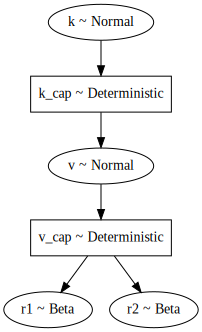

In [10]:
pm.model_to_graphviz(bayesian_lerner_model_2dim)

In [75]:
# 整理结果
del(k_list[0])
del(v_list[0])
del(r1_list[0])
del(r2_list[0])

results_model3 = {'k_list': k_list, 'v_list': v_list, 
                  'r1_list': r1_list, 'r2_list': r2_list, 
                  'k_cap': k_cap, "v_cap": v_cap}

1


In [32]:
zipped_data

In [33]:
list(zipped_data)

[]